# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

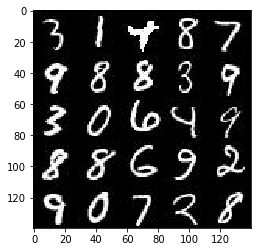

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

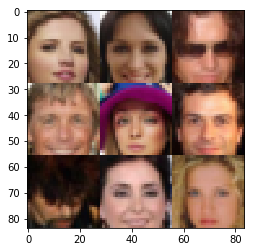

In [3]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,
                               shape=(None,image_width,image_height,image_channels),
                              name = 'real_input')
    input_z = tf.placeholder(tf.float32,
                            shape = (None, z_dim),
                            name = 'input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    
    return real_input, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    weight_init = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(inputs = images, 
                              filters = 64, 
                              kernel_size = 3, 
                              strides=2, 
                              kernel_initializer = weight_init,
                              use_bias=False,
                              padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)        
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(inputs = x1, 
                              filters = 128, 
                              kernel_size = 3, 
                              strides=2, 
                              kernel_initializer = weight_init,
                              use_bias=False,
                              padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)        
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(inputs = x2,
                              filters = 256, 
                              kernel_size =3, 
                              strides=2, 
                              kernel_initializer = weight_init,
                              use_bias=False,
                              padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    weight_init = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # 7x7x256 now
        
        # second layeer convolution
        x2 = tf.layers.conv2d_transpose(inputs = x1, 
                                        filters = 128, 
                                        kernel_size = 3, 
                                        strides=2, 
                                        kernel_initializer = weight_init,
                                        use_bias=False,
                                        padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)        
        x2 = tf.maximum(alpha * x2, x2)

        # 14x14x128 now
        
        # third layer- convolution
        x3 = tf.layers.conv2d_transpose(inputs = x2, 
                                        filters = 64, 
                                        kernel_size = 3, 
                                        strides=2, 
                                        kernel_initializer = weight_init,
                                        use_bias=False,
                                        padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)        
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        # fourth layer - 1D convolution
        x4 = tf.layers.conv2d_transpose(inputs = x3, 
                                        filters = 64, 
                                        kernel_size = 1, 
                                        strides=1, 
                                        kernel_initializer = weight_init,
                                        use_bias=False,
                                        padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)        
        x4 = tf.maximum(alpha * x4, x4)
                

        
        # Output layer
        logits = tf.layers.conv2d_transpose(inputs =x4, 
                                            filters = out_channel_dim, 
                                            kernel_size = 3, 
                                            strides=1, 
                                            kernel_initializer = weight_init,
                                            use_bias=False,
                                            padding='same')
        # 28x28xOut_channel_dim now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=0.95*tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
#     input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
#     d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
#     d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
class GAN:
    def __init__(self, data_shape, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z,lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              data_shape[3], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)    

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    net = GAN(data_shape, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # normalize batch images to <-1,1>
                batch_images = batch_images*2
                # print(batch_images.max(),batch_images.min())
               
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                #_ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})                

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7249... Generator Loss: 5.0674
Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 1.8158
Epoch 1/2... Discriminator Loss: 1.8765... Generator Loss: 0.2799
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.4871
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.7112
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 1.3024
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.7638


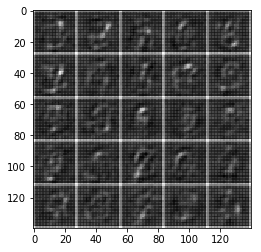

Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.5154... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 1.1540
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 1.0071
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.4753
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 1.5644


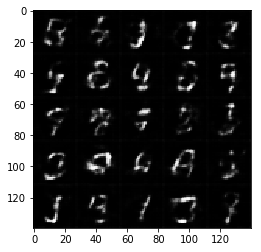

Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 1.9177
Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.3658
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 1.9800
Epoch 1/2... Discriminator Loss: 1.4648... Generator Loss: 0.3846
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 1.7840
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 1.8237
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 1.9412
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.9736
Epoch 1/2... Discriminator Loss: 1.1104... Generator Loss: 0.8549
Epoch 1/2... Discriminator Loss: 1.5576... Generator Loss: 0.3557


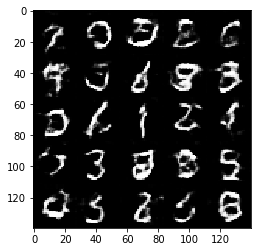

Epoch 1/2... Discriminator Loss: 1.2715... Generator Loss: 0.5073
Epoch 1/2... Discriminator Loss: 1.0468... Generator Loss: 1.3475
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.8631
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.3916
Epoch 1/2... Discriminator Loss: 1.1999... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.3885
Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 1.3007
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 0.6859


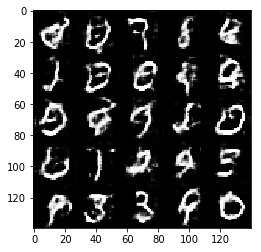

Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 1.9267
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.6774
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.1120
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 0.9213
Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.8926
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.6232


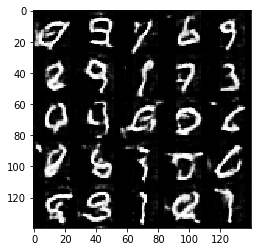

Epoch 1/2... Discriminator Loss: 1.2167... Generator Loss: 0.6275
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 0.5100
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.3084
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 2.5484
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 0.9081
Epoch 1/2... Discriminator Loss: 1.4338... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.3749
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.2918
Epoch 1/2... Discriminator Loss: 1.5709... Generator Loss: 1.8141


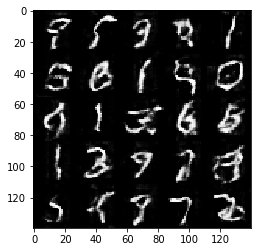

Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.5626
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 1.3184
Epoch 1/2... Discriminator Loss: 1.5867... Generator Loss: 0.3635
Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 0.7995
Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 0.9003
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.4308
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.6197


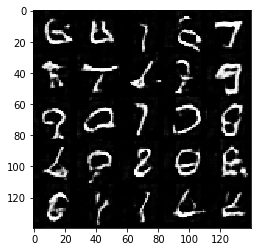

Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.6618
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.5977
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.1873
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.6817
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 0.6016
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 1.7682
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 0.9383... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.4990


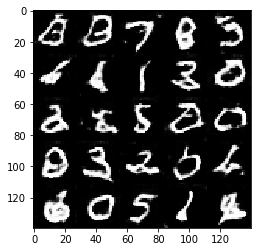

Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 0.8106... Generator Loss: 1.3025
Epoch 1/2... Discriminator Loss: 1.7383... Generator Loss: 0.2714
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.8251


IndexError: list index out of range

In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9257... Generator Loss: 0.3187
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 1.4735
Epoch 1/1... Discriminator Loss: 1.8943... Generator Loss: 0.3298
Epoch 1/1... Discriminator Loss: 1.9473... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.9643... Generator Loss: 0.3139
Epoch 1/1... Discriminator Loss: 2.1307... Generator Loss: 0.2086
Epoch 1/1... Discriminator Loss: 2.3085... Generator Loss: 0.1654
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6345


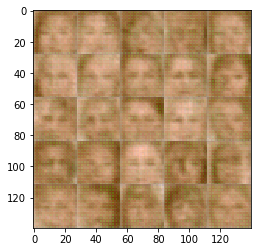

Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 1.1381
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.4332
Epoch 1/1... Discriminator Loss: 1.6195... Generator Loss: 0.4663
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.9983... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.8851... Generator Loss: 0.2700
Epoch 1/1... Discriminator Loss: 1.6908... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.5841


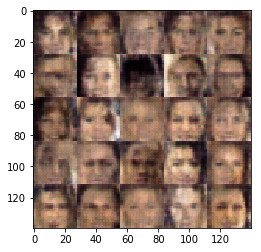

Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.7189... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.7389... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.6448... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.8873... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.7074... Generator Loss: 0.3625


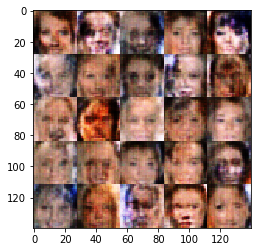

Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.5959... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.5968


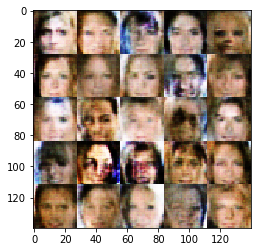

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 1.6156... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6004


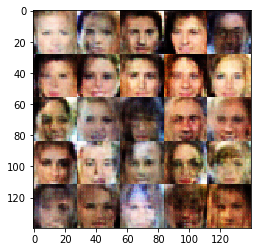

Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.6850... Generator Loss: 1.4038
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.6588


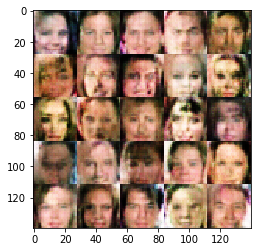

Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.4604
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.3220
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 1.1006


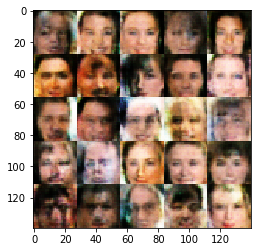

Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6188
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7656


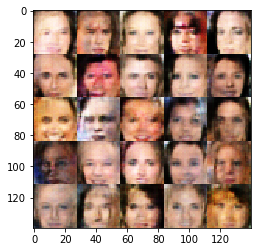

Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.5130


IndexError: list index out of range

In [32]:
batch_size = 64
z_dim = 150
learning_rate = 0.0005
beta1 = 0.4
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha = alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

# Comment
I was experimenting with batch_norm placement, before the RELU and After. The visual  results are better when placing the batch_norm before the RELU.

I have read the discussion on slack#Project-5 and use the trick to run generator twice to better compeete with discriminator. But didnt see any improvment in generated faces